In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

# Определим текущую дату
current_date = datetime.now()

## Задача
1. Прогнозирование спроса в онлайн ритейле

Описание датасета
    Описание: Уникальный 6-значный целочисленный номер, присвоенный каждой транзакции. Если этот код начинается с буквы 'C', это указывает на отмену.
    Единицы измерения: нет
    Пропущенные значения: нет
    StockCode (ID, Categorical)

Описание: Уникальный 5-значный целочисленный номер, присвоенный каждому отдельному продукту.
   Единицы измерения: нет
   Пропущенные значения: нет
   Description (Feature, Categorical)

Описание: Наименование продукта.
   Единицы измерения: нет
   Пропущенные значения: нет
   Quantity (Feature, Integer)

Описание: Количество каждого продукта (единицы) на одну транзакцию.
   Единицы измерения: нет
   Пропущенные значения: нет
   InvoiceDate (Feature, Date)

Описание: День и время, когда была создана каждая транзакция.
   Единицы измерения: нет
   Пропущенные значения: нет
   UnitPrice (Feature, Continuous)

Описание: Цена продукта за единицу.
   Единицы измерения: фунты стерлингов
   Пропущенные значения: нет
   CustomerID (Feature, Categorical)

Описание: Уникальный 5-значный целочисленный номер, присвоенный каждому клиенту.
   Единицы измерения: нет
   Пропущенные значения: нет
   Country (Feature, Categorical)

Описание: Название страны, где проживает каждый клиент.
   Единицы измерения: нет
   Пропущенные значения: нет

In [124]:
PATH_SERIES = '../../src/walmart/'
features_file = "Online Retail.xlsx"
features_df = pd.read_excel(PATH_SERIES + features_file)
print(features_df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [125]:
# Просмотр информации о данных и проверка на пропуски
print(features_df.info())

# Подсчет пропущенных значений в каждом столбце
missing_values = features_df.isnull().sum()
print("\nКоличество пропусков в каждом столбце:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Количество пропусков в каждом столбце:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [126]:
# Замена пропусков в столбце Description на "Прочие"
features_df['Description'].fillna('Прочие', inplace=True)

# Замена пропусков в столбце CustomerID на -999999 (или можно на "Прочие", как угодно)
features_df['CustomerID'].fillna(-999999, inplace=True)

# Замена пустых значений в поле InvoiceNo на "без номера"
features_df['InvoiceNo'].fillna('без номера', inplace=True)

# Добавление фичи "возврат" на основе поля InvoiceNo
features_df['Return'] = features_df['InvoiceNo'].astype(str).str.startswith('C').astype(int)

# Проверка, что все пропуски были заполнены
print(features_df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Return         0
dtype: int64


In [127]:
# Фильтрация датасета по полю Return равному 1
return_transactions = features_df.loc[features_df['Return'] == 1]

# Вывод первых нескольких строк отфильтрованного датасета
print(return_transactions.head())

    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  Return  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom       1  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom       1  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom       1  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom       1  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom       1  


In [128]:
# Проверка наличия заказов с минусом (отрицательное количество)
negative_quantity = features_df[features_df['Quantity'] > 0]
print("Заказы с + количеством:")
print(negative_quantity.head())

# Проверка наличия возвратов (по полю Return)
returns = features_df[features_df['Return'] == 1]
print("\nВозвраты:")
print(returns.head(), len(returns))

Заказы с + количеством:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Return  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       0  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       0  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       0  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       0  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       0  

Возвраты:
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D            

In [129]:
features_df[(features_df['Return'] != 1) & (features_df['Quantity'] > 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0


In [130]:
# выводим топ позиций опасания товара для 
features_df['Description'].value_counts().head(5)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

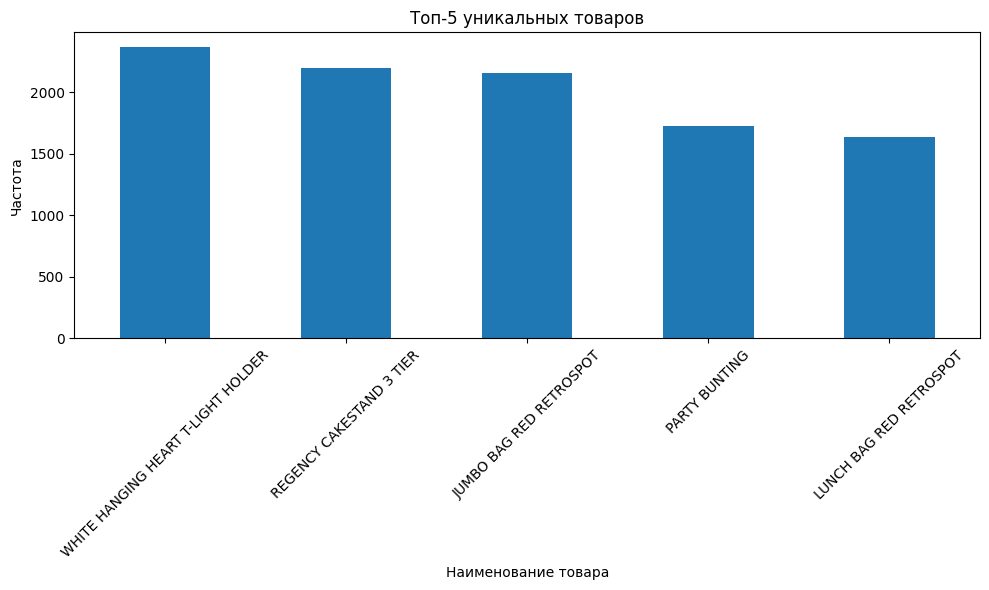

In [131]:
plt.figure(figsize=(10, 6))
features_df['Description'].value_counts().head(5).plot(kind='bar')
plt.xlabel('Наименование товара')
plt.ylabel('Частота')
plt.title('Топ-5 уникальных товаров')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [132]:
features_df['InvoiceDate'] = pd.to_datetime(features_df['InvoiceDate'])


In [133]:
features_df['Description'].value_counts()[:15]

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
Прочие                                1454
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
POSTAGE                               1252
JUMBO BAG PINK POLKADOT               1251
HEART OF WICKER SMALL                 1237
JAM MAKING SET WITH JARS              1229
Name: count, dtype: int64

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avsip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avsip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avsip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.typ

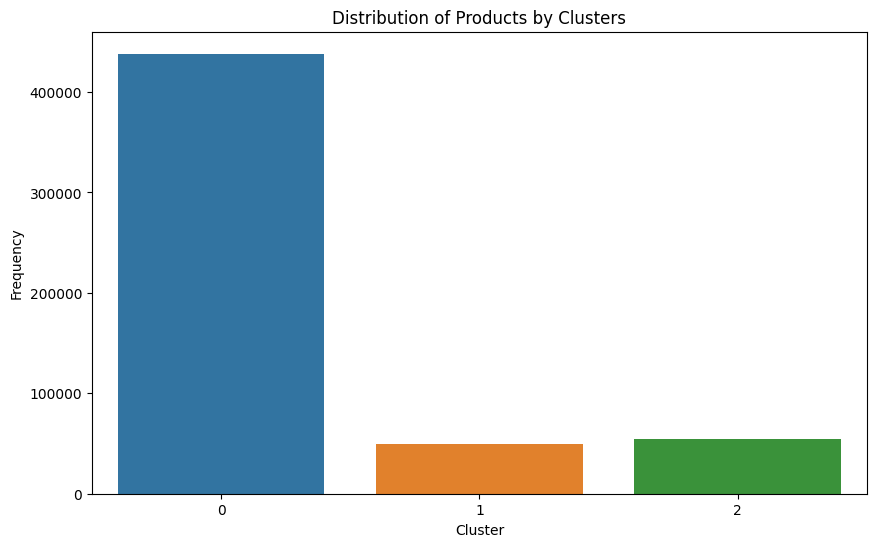

Cluster 0:
1                     WHITE METAL LANTERN
3     KNITTED UNION FLAG HOT WATER BOTTLE
5            SET 7 BABUSHKA NESTING BOXES
7                  HAND WARMER UNION JACK
8               HAND WARMER RED POLKA DOT
9           ASSORTED COLOUR BIRD ORNAMENT
10             POPPY'S PLAYHOUSE BEDROOM 
11              POPPY'S PLAYHOUSE KITCHEN
12      FELTCRAFT PRINCESS CHARLOTTE DOLL
13                IVORY KNITTED MUG COSY 
Name: Description, dtype: object

Cluster 1:
38       CHARLOTTE BAG DOLLY GIRL DESIGN
86               JUMBO BAG PINK POLKADOT
87        JUMBO  BAG BAROQUE BLACK WHITE
88       JUMBO BAG CHARLIE AND LOLA TOYS
89              STRAWBERRY CHARLOTTE BAG
93               LUNCH BAG RED RETROSPOT
103               JUMBO STORAGE BAG SUKI
104       JUMBO BAG PINK VINTAGE PAISLEY
108    JUMBO SHOPPER VINTAGE RED PAISLEY
116                   SKULL SHOULDER BAG
Name: Description, dtype: object

Cluster 2:
0     WHITE HANGING HEART T-LIGHT HOLDER
2         CREAM CUPID HEARTS

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return " ".join(tokens)
    else:
        return "unknown"
features_df['CleanedDescription'] = features_df['Description'].apply(preprocess_text)
features_df = features_df[features_df['CleanedDescription'] != 'unknown']
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(features_df['CleanedDescription'])
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)
features_df['Cluster'] = clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=features_df)
plt.title('Distribution of Products by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()


for cluster_id in range(k):
    print(f"Cluster {cluster_id}:")
    print(features_df[features_df['Cluster'] == cluster_id]['Description'].head(10))
    print()

In [135]:
features_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,CleanedDescription,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,white hanging heart tlight holder,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,white metal lantern,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,cream cupid heart coat hanger,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,knitted union flag hot water bottle,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,red woolly hottie white heart,2
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,pack of 20 spaceboy napkin,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,childrens apron dolly girl,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery dolly girl,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery circus parade,0


<Figure size 800x600 with 0 Axes>

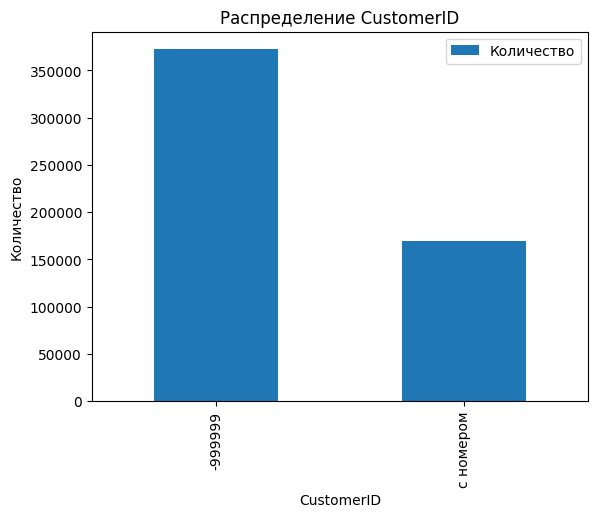

In [142]:
customer_counts = features_df['CustomerID'].value_counts()

# Определяем категории "Прочие" и "Остальные"
other_count = customer_counts[customer_counts < customer_counts.nlargest(10).min()].sum()
top_counts = customer_counts.nlargest(10)

# Создаем DataFrame с данными для графика
chart_data = pd.DataFrame({
    'CustomerID': ['-999999', 'c номером'],
    'Количество': [other_count, top_counts.sum()]
})

# Построение графика
plt.figure(figsize=(8, 6))
chart_data.plot(x='CustomerID', y='Количество', kind='bar')
plt.title('Распределение CustomerID')
plt.xlabel('CustomerID')
plt.ylabel('Количество')
plt.show()

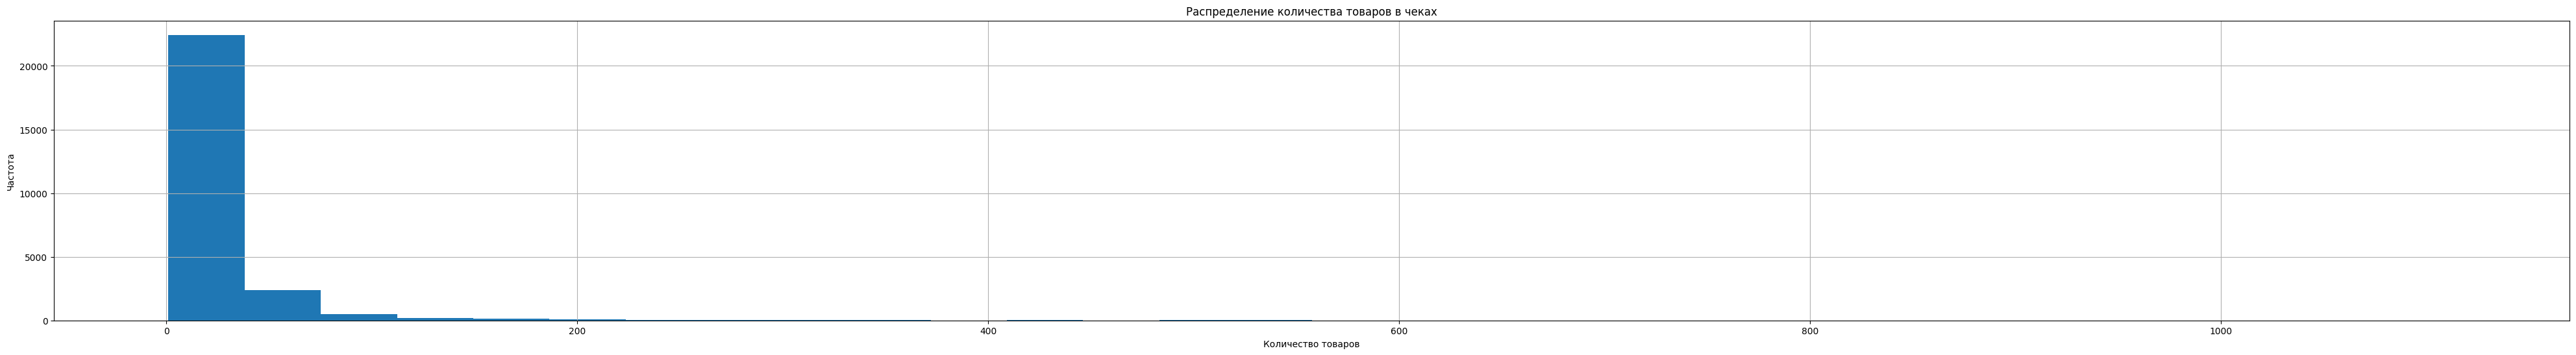

In [161]:
invoice_counts = features_df.groupby('InvoiceNo').size()

# Построение гистограммы
plt.figure(figsize=(50, 6))
invoice_counts.hist(bins=30)
plt.title('Распределение количества товаров в чеках')
plt.xlabel('Количество товаров')
plt.ylabel('Частота')
plt.show()

In [155]:
features_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,CleanedDescription,Cluster,Category_group
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,white hanging heart tlight holder,3,Прочие
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,white metal lantern,1,Прочие
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,cream cupid heart coat hanger,3,Прочие
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,knitted union flag hot water bottle,1,Прочие
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,red woolly hottie white heart,3,Прочие
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,pack of 20 spaceboy napkin,0,Прочие
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,childrens apron dolly girl,1,Игрушки
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery dolly girl,1,Игрушки
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery circus parade,1,Прочие


In [165]:
import holidays

# Предположим, что ваш DataFrame называется 'features_df'
features_df['InvoiceDate'] = pd.to_datetime(features_df['InvoiceDate'])

# Создаем столбец с днем недели
features_df['День недели'] = features_df['InvoiceDate'].dt.day_name()

# Создаем столбец с признаком праздника
us_holidays = holidays.US()
features_df['Праздник'] = features_df['InvoiceDate'].dt.date.isin(us_holidays)

# Создаем столбец с датой
features_df['Дата'] = features_df['InvoiceDate'].dt.date

# Создаем столбец с неделей в году
features_df['Неделя в году'] = features_df['InvoiceDate'].dt.isocalendar().week

# Оставляем только год из даты
features_df['Год'] = features_df['InvoiceDate'].dt.year

In [166]:
features_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,CleanedDescription,Cluster,Category_group,День недели,Праздник,Дата,Неделя в году,Год
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,white hanging heart tlight holder,3,Прочие,Wednesday,False,2010-12-01,48,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,white metal lantern,1,Прочие,Wednesday,False,2010-12-01,48,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,cream cupid heart coat hanger,3,Прочие,Wednesday,False,2010-12-01,48,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,knitted union flag hot water bottle,1,Прочие,Wednesday,False,2010-12-01,48,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,red woolly hottie white heart,3,Прочие,Wednesday,False,2010-12-01,48,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,pack of 20 spaceboy napkin,0,Прочие,Friday,False,2011-12-09,49,2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,childrens apron dolly girl,1,Игрушки,Friday,False,2011-12-09,49,2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery dolly girl,1,Игрушки,Friday,False,2011-12-09,49,2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,childrens cutlery circus parade,1,Прочие,Friday,False,2011-12-09,49,2011


d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

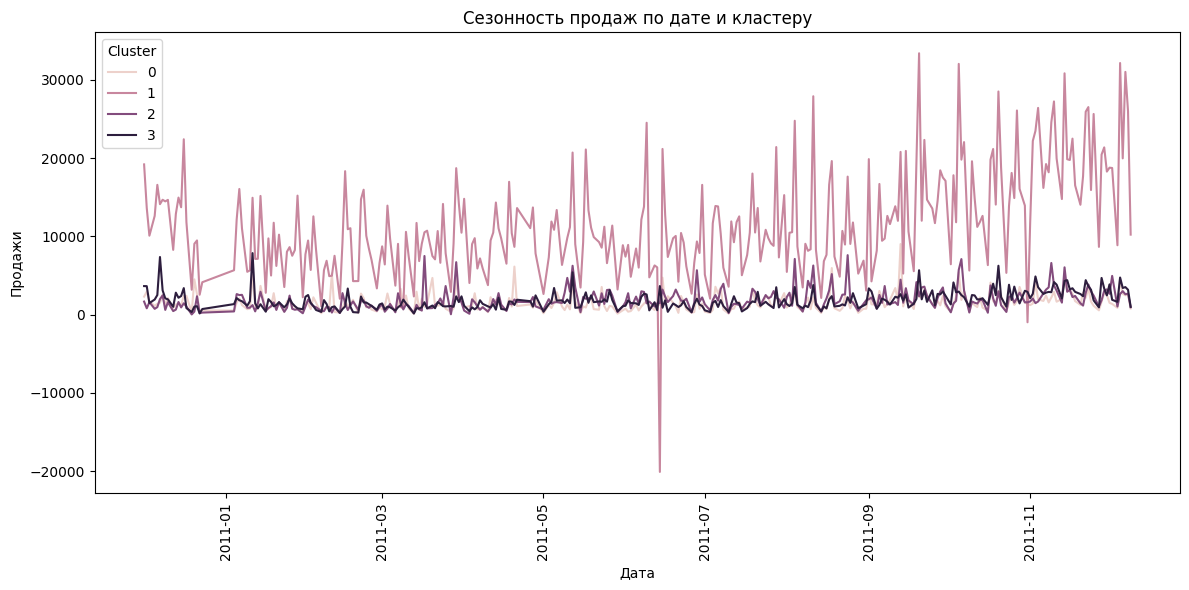

In [172]:
# Группируем данные по дате и кластеру, считаем сумму продаж
sales_by_date_cluster = features_df.groupby(['Дата', 'Cluster'])['Quantity'].sum().reset_index()

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(12, 6))

# Строим график сезонности продаж по дате и кластеру
sns.lineplot(x='Дата', y='Quantity', hue='Cluster', data=sales_by_date_cluster, ax=ax)

# Настраиваем оформление графика
ax.set_title('Сезонность продаж по дате и кластеру')
ax.set_xlabel('Дата')
ax.set_ylabel('Продажи')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# попытка проанализировать кластеры на адекватность

In [136]:
# Предобработка текста
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

# Применение предобработки к описаниям товаров
features_df['CleanedDescription'] = features_df['Description'].apply(preprocess_text)

# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(features_df['CleanedDescription'])

# Кластеризация с помощью K-means
k = 4  # Задаем число кластеров
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Добавление кластеров в датасет
features_df['Cluster'] = clusters

# Выводим все кластеры и топ слова в каждом
top_words_per_cluster = {}
for cluster_id in range(k):
    # Выбираем описания товаров из текущего кластера
    cluster_df = features_df[features_df['Cluster'] == cluster_id]
    # Собираем все тексты описаний товаров в текущем кластере
    cluster_text = ' '.join(cluster_df['CleanedDescription'])
    # Разделяем текст на отдельные слова
    words = cluster_text.split()
    # Считаем частоту каждого слова
    word_freq = nltk.FreqDist(words)
    # Выбираем топ-10 самых частых слов
    top_words = word_freq.most_common(10)
    # Сохраняем топ слов для текущего кластера
    top_words_per_cluster[cluster_id] = top_words

# Выводим результаты
for cluster_id, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_id}:")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print()

d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
cake: 22764
of: 18240
pack: 12238
case: 10603
paper: 7495
set: 7122
retrospot: 6715
60: 5951
12: 5884
fairy: 5338

Cluster 1:
set: 44017
of: 29625
red: 27584
box: 27274
vintage: 22415
pink: 20140
metal: 19344
retrospot: 18835
christmas: 18588
sign: 16998

Cluster 2:
bag: 48281
jumbo: 20172
lunch: 13793
red: 9481
design: 9415
retrospot: 8334
vintage: 7759
charlotte: 5882
paisley: 5030
pink: 4930

Cluster 3:
heart: 42078
tlight: 12906
hanging: 12346
holder: 12306
decoration: 7481
white: 6291
of: 5486
small: 5054
wicker: 4984
glass: 4462



['Прочие' 'Игрушки' 'Мебель' 'Одежда']


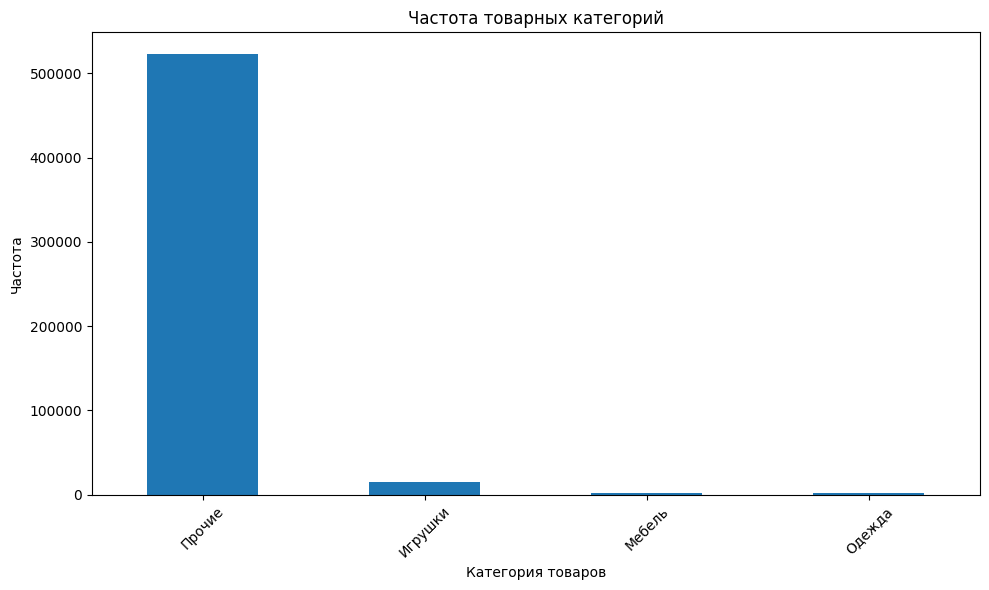

In [139]:
# Создание столбца с категориями на основе функции
features_df['Category_group'] = features_df['Description'].apply(categorize_description)

# Просмотр уникальных категорий
print(features_df['Category_group'].unique())

# Просмотр частоты категорий
plt.figure(figsize=(10, 6))
features_df['Category_group'].value_counts().plot(kind='bar')
plt.xlabel('Категория товаров')
plt.ylabel('Частота')
plt.title('Частота товарных категорий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# первичный анализ датасета
1. есть данные по возвратам
2. данные по названию товаров не выделены в группы
3. доля прочих клиентов не имеющих ID велика
4. каждая транзакция разбита отдельно по товарам в 1 покупке
5. есть отрицательные или 0 суммы в продажах они соответствуют возвратам
6. важно учитывать локацию продаж, так как наблюдается явная доля одной локации

Идеи и гипотезы:
1. всех пользователей которые без ID выделить в прочие, возможно или это недочеты датасета или прочие (иные каналы сбыта)
2. выделить долю транзакций в которых были сделаны возвраты (['все товары в заказе', 'частичный возврат'])
3. добавить фичи, выходные дни, дни недели, месяц, для возможности смены масштаба
4. доработать кластеризацию товаров, и выделить в них топ категорий для анализа или выделить топ категорий по сумме продаж, в разрезе каждой локации
5. после этого, делать более глубокий анализ сезонности продаж
6. далее делать прогноз продаж а так же долю возвратов
7. отдельно можно выделить частоту совершения транзакций для тех покупателей у которых есть ID, для учета данного прогноза в случае увеличения доли потребителей, может оказаться что покупатели совершают не регулярные покупки